In [1]:
import pandas as pd
debt_market_df = pd.read_csv('debt_market_df.csv', index_col='date', parse_dates=True)

In [2]:
# Store the last model in a file and load it to check the predictions match
import pickle
loaded_model = pickle.load(open('debt_price_estimator.pickle', 'rb'))

features = ['beta', 'Q', 'v_1', 'v_2 + v_3', 
            'rho_star', 'C_star',
            'D_1', 'u_1', 'u_2', 'u_3', 'u_2 + u_3', 
            'D_2', 'w_1', 'w_2', 'w_3', 'w_2 + w_3',
            'D']

data_to_predict = debt_market_df[features]
loaded_model_predictions = loaded_model.predict(data_to_predict)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyparsing.py:3172: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


In [3]:
autoreg_df = debt_market_df[['p', 'p_star']].copy()
autoreg_df['p_hat'] = loaded_model_predictions
autoreg_df['e_hat'] = autoreg_df['p_hat'] - autoreg_df['p']
autoreg_df['e_star'] = autoreg_df['p_star'] - autoreg_df['p']
autoreg_df['cumsum_e_hat'] = autoreg_df['e_hat'].cumsum()
autoreg_df['cumsum_e_star'] = autoreg_df['e_star'].cumsum()
autoreg_df['delta_e_hat'] = autoreg_df['e_hat'].diff().fillna(autoreg_df['e_hat'])
autoreg_df['delta_e_star'] = autoreg_df['e_star'].diff().fillna(autoreg_df['e_star'])
autoreg_df['y'] = autoreg_df['p'].shift(-1)
autoreg_df.dropna(inplace=True)
autoreg_df.to_csv('market_price_autoregression_df.csv')

0.5461900466167436
[ 0.75669066  0.85146313 -0.75669066  0.11001546  0.00399161 -0.01917906
  0.2225983 ]
0.2403649323606324


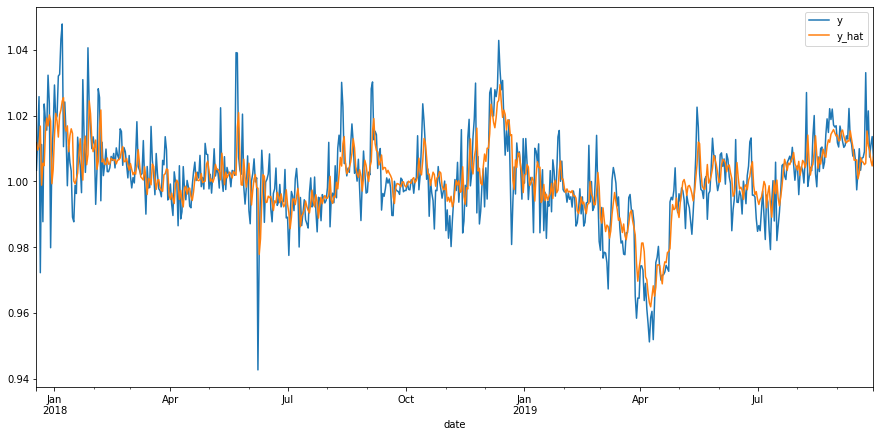

In [5]:
import numpy as np
from sklearn.linear_model import LinearRegression
X = autoreg_df[['p', 
                'e_hat', 'e_star', 
                'cumsum_e_hat', 'cumsum_e_star', 
                'delta_e_hat', 'delta_e_star']]
y = autoreg_df['y']

reg = LinearRegression().fit(X.sample(n=400,random_state=1), y.sample(n=400,random_state=1))
print(reg.score(X, y))
print(reg.coef_)
print(reg.intercept_)
autoreg_df['y_hat'] = reg.predict(X)

autoreg_df.plot(y=['y','y_hat'], figsize=(15,7))

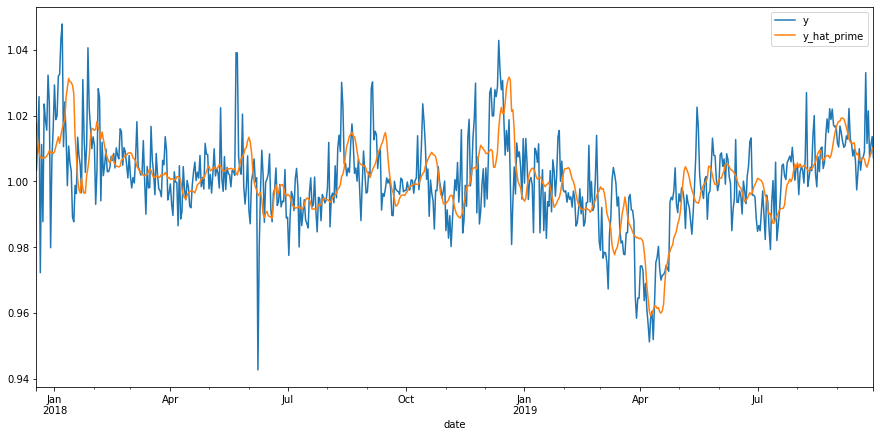

In [6]:
y_hat_prime = [autoreg_df['p'].iloc[0]]
prev_e_hat = 0
prev_e_star = 0
cumsum_e_hat = 0
cumsum_e_star = 0
for i,r in autoreg_df.iterrows():
    p = y_hat_prime[-1]
    e_hat = r['p_hat'] - p
    e_star = r['p_star'] - p
    cumsum_e_hat += e_hat
    cumsum_e_star += e_star
    delta_e_hat = e_hat - prev_e_hat
    delta_e_star = e_star - prev_e_star
    pred = (p * reg.coef_[0] +
            e_hat * reg.coef_[1] + 
            e_star * reg.coef_[2] +
            cumsum_e_hat * reg.coef_[3] +
            cumsum_e_star * reg.coef_[4] +
            delta_e_hat * reg.coef_[5] +
            delta_e_star * reg.coef_[6] +
            reg.intercept_)
    y_hat_prime.append(pred)
autoreg_df['y_hat_prime'] = y_hat_prime[:-1]
autoreg_df.plot(y=['y','y_hat_prime'], figsize=(15,7))